In [17]:
import os
os.environ[ 'NUMBA_CACHE_DIR' ] = '/scratch/st-jiaruid-1/yinian/tmp/' # https://github.com/scverse/scanpy/issues/2113

import h5py
import hdf5plugin
import tables

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import scanpy as sc
import anndata as ad

In [2]:
sc.set_figure_params(dpi=100)

## Load the scRNA-seq data

In [3]:
base_dir = '/arc/project/st-jiaruid-1/yinian/multiome/'
filenames = [
    'test_cite_inputs', 
#     'test_multi_inputs', 
    'train_cite_inputs',
#     'train_cite_targets',
#     'train_multi_inputs',
#     'train_multi_targets',
]

In [4]:
metadata_df = pd.read_csv('/arc/project/st-jiaruid-1/yinian/multiome/metadata.csv')
metadata_df = metadata_df.set_index('cell_id')

In [5]:
adatas = {}
chunk_size = 10000

for filename in filenames:
    print(f'loading {filename}.h5')
    filepath = base_dir + filename + '.h5'
    
    h5_file = h5py.File(filepath)
    h5_data = h5_file[filename]
    
    features = h5_data['axis0'][:]
    cell_ids = h5_data['axis1'][:]
    
    features = features.astype(str)
    cell_ids = cell_ids.astype(str)
    
    technology = metadata_df.loc[cell_ids, 'technology'].unique().item()
    
    if technology == 'multiome':
        sparse_chunks = []
        n_cells = h5_data['block0_values'].shape[0]
        
        for chunk_indices in np.array_split(np.arange(n_cells), 100):
            chunk = h5_data['block0_values'][chunk_indices]
            sparse_chunk = scipy.sparse.csr_matrix(chunk)
            sparse_chunks.append(sparse_chunk)
            
        X = scipy.sparse.vstack(sparse_chunks)
    elif technology == 'citeseq':
        X = h5_data['block0_values'][:]
        
    adata = ad.AnnData(
        X=X,
        obs=metadata_df.loc[cell_ids],
        var=pd.DataFrame(index=features),
    )
    
    adatas[filename] = adata

loading test_cite_inputs.h5
loading train_cite_inputs.h5


In [6]:
rna_adata = ad.concat([adatas['test_cite_inputs'], adatas['train_cite_inputs']])

## Get the top genes per cell type

In [7]:
def gex_de_analysis(adata_GEX, top_genes):
    """get top DE genes per cell type (multiome)"""
    sc.pp.filter_cells(adata_GEX, min_genes=200)
    sc.pp.filter_genes(adata_GEX, min_cells=3)
    adata_GEX.var["mt"] = adata_GEX.var_names.str.contains("MT-")
    sc.pp.calculate_qc_metrics(
        adata_GEX, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    adata_GEX = adata_GEX[adata_GEX.obs.n_genes_by_counts < 4000, :]
    sc.pp.normalize_total(adata_GEX, target_sum=1e4)
    sc.pp.log1p(adata_GEX)
    sc.pp.highly_variable_genes(adata_GEX, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pp.scale(adata_GEX, max_value=10)
    sc.tl.rank_genes_groups(adata_GEX, "cell_type", method="wilcoxon")
    cell_types = adata_GEX.obs.cell_type.value_counts().index
    column_names = [
        "names",
        "scores",
        "logfoldchanges",
        "pvals",
        "pvals_adj",
        "cell_type",
    ]
    df = pd.DataFrame(columns=column_names)
    for cell_type in cell_types:
        dedf = sc.get.rank_genes_groups_df(adata_GEX, group=cell_type)
        dedf["cell_type"] = cell_type
        dedf = dedf.sort_values("scores", ascending=False).iloc[:top_genes]
        df = df.append(dedf, ignore_index=True)
    return df

In [8]:
genes = gex_de_analysis(rna_adata.copy(), 250)

/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/arc/project/st-jiaruid-1/yinian/tensorflow-gpu/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: inval

## Visualize correlation matrix for each cell type

In [13]:
def corr_matrix(rna_adata, genes, cell_type:str):
    genes_cell_type = genes[genes['cell_type'] == cell_type]
    subset = set(genes_cell_type.names).intersection(rna_adata.var_names)
    rna_adata = rna_adata[:, list(subset)]
    df = pd.DataFrame(rna_adata.X)
    corr = df.corr()
    with open('corr_' + cell_type + '.pkl', 'wb') as f:
        pickle.dump(corr, f)
    return corr

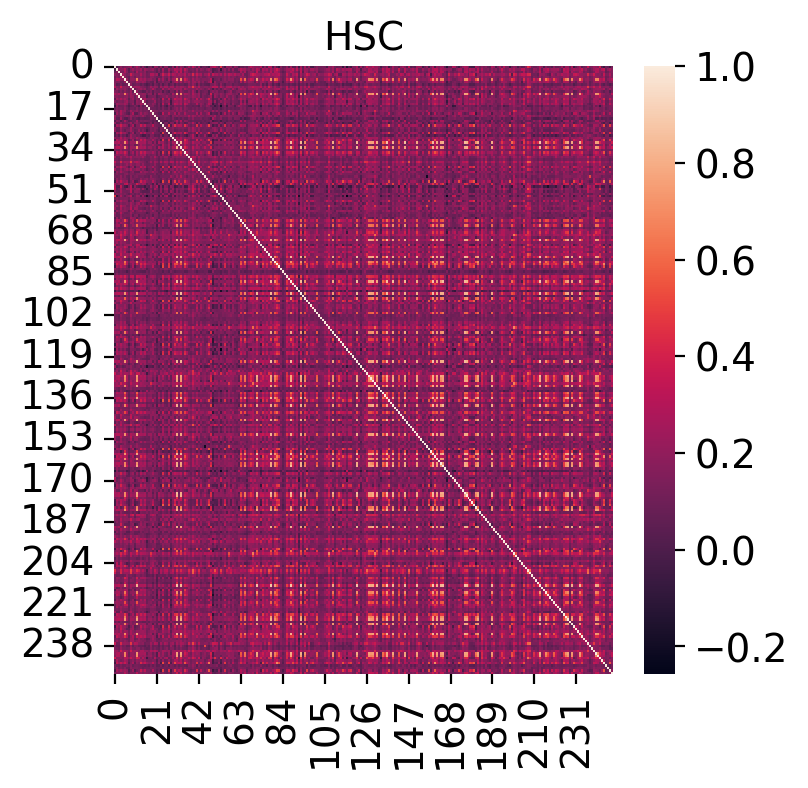

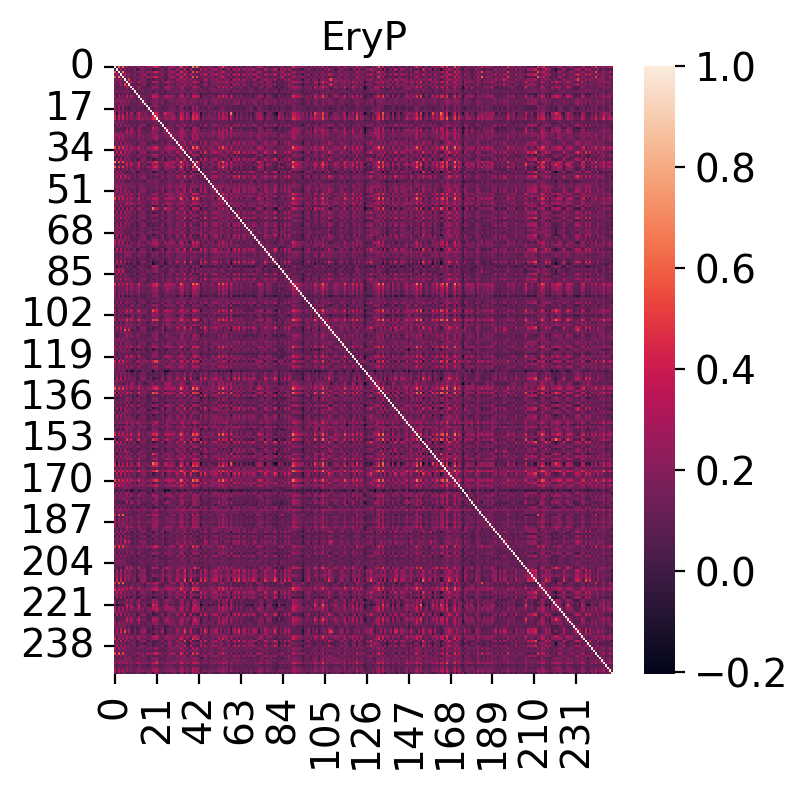

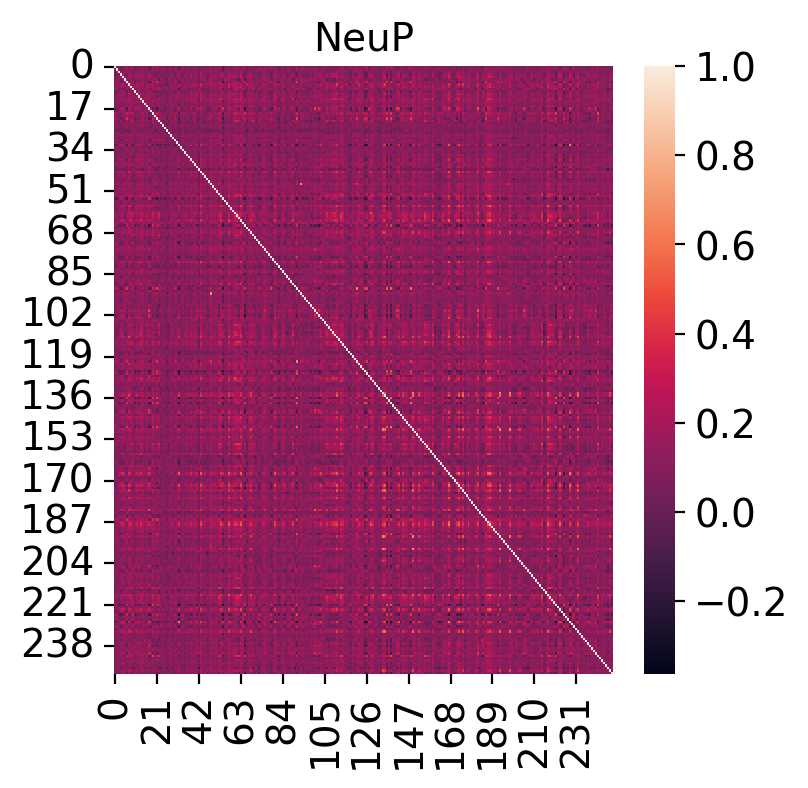

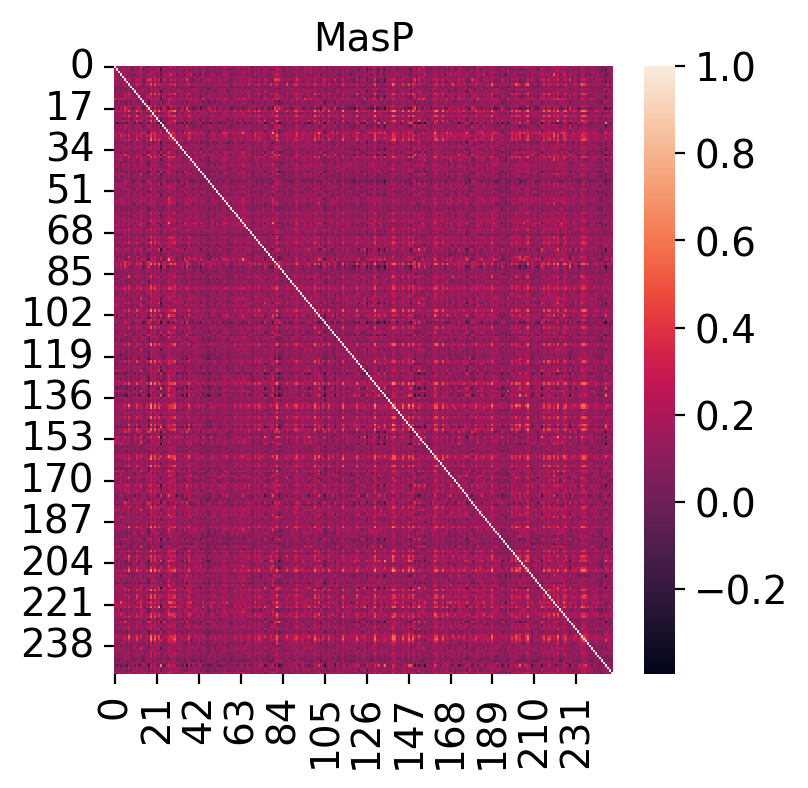

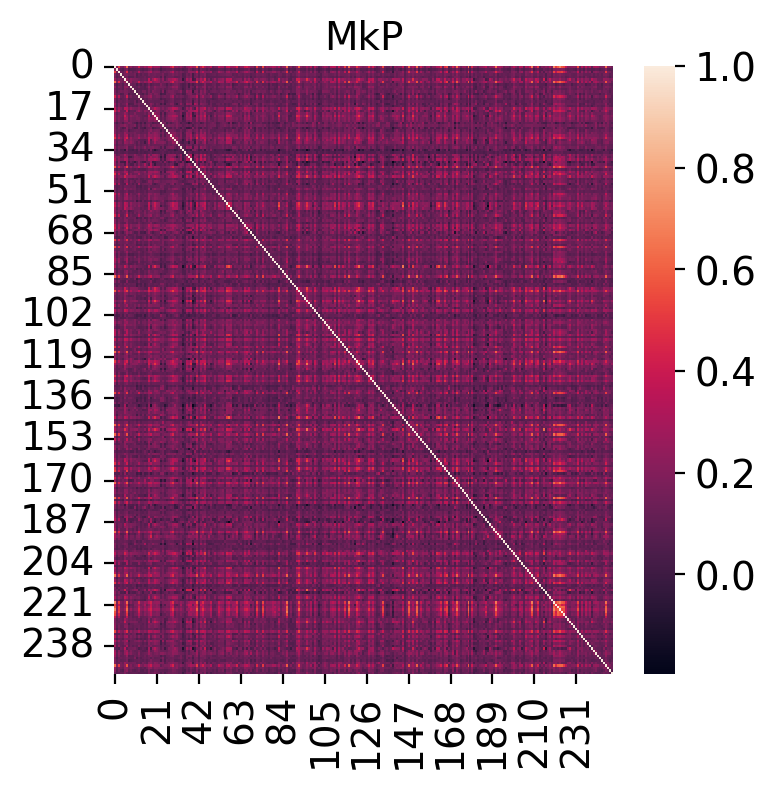

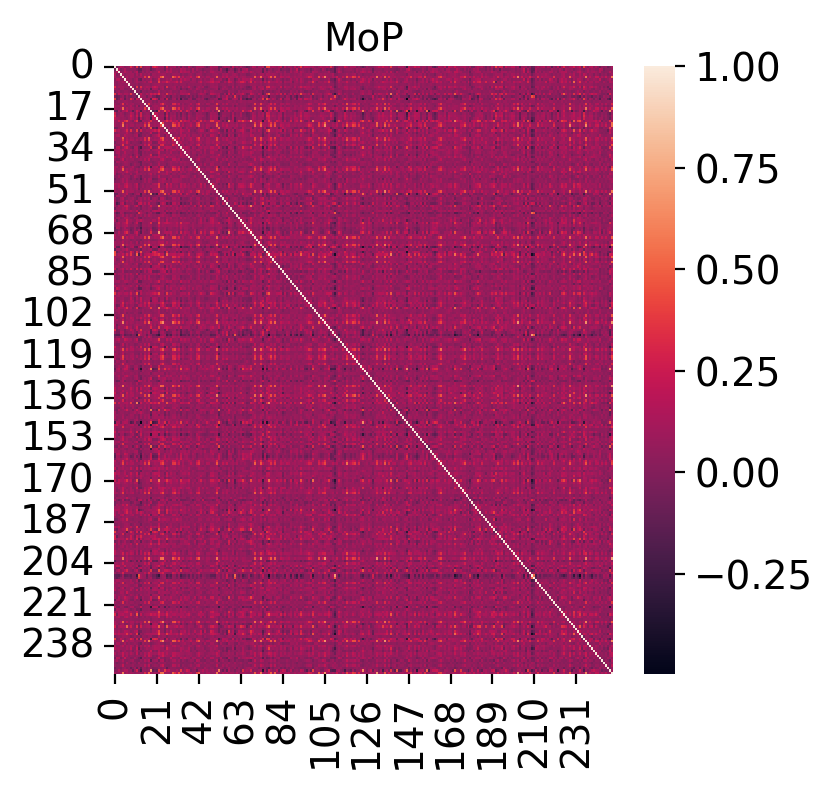

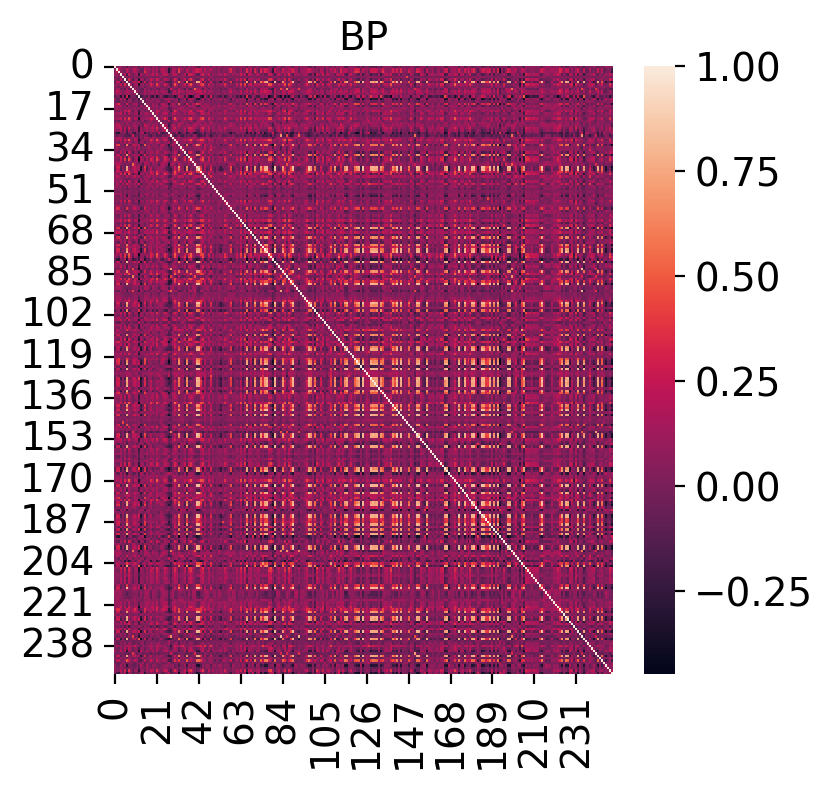

In [18]:
for cell_type in rna_adata.obs.cell_type.value_counts().index:
    corr = corr_matrix(rna_adata, genes, cell_type)
    sns.heatmap(corr)
    plt.title(cell_type)
    plt.show()

## What are the genes with correlation > 0.8 or <-0.8?

In [37]:
for cell_type in rna_adata.obs.cell_type.value_counts().index:
    corr = corr_matrix(rna_adata, genes, cell_type)
    genes_cell_type = genes[genes['cell_type'] == cell_type]
    subset = list(set(genes_cell_type.names).intersection(rna_adata.var_names))
    print('=' * 20 + cell_type + '=' * 20)
    for i in range(corr.shape[1]):
        indices = corr.index[corr[i] > 0.8].tolist()
        for index in indices:
            if index < i:
                print(subset[i], subset[index], corr[i][index])    

====================HSC====================
ENSG00000162244_RPL29 ENSG00000100316_RPL3 0.8006808199000454
ENSG00000186468_RPS23 ENSG00000100316_RPL3 0.8093131933179504
ENSG00000142676_RPL11 ENSG00000100316_RPL3 0.8308848723010688
ENSG00000142676_RPL11 ENSG00000162244_RPL29 0.8083959309990847
ENSG00000142676_RPL11 ENSG00000186468_RPS23 0.8171861204377779
ENSG00000167526_RPL13 ENSG00000100316_RPL3 0.8485833860361736
ENSG00000167526_RPL13 ENSG00000162244_RPL29 0.8031979133642412
ENSG00000167526_RPL13 ENSG00000186468_RPS23 0.8267159487702382
ENSG00000167526_RPL13 ENSG00000142676_RPL11 0.8462738778127976
ENSG00000105640_RPL18A ENSG00000100316_RPL3 0.8257398264412897
ENSG00000105640_RPL18A ENSG00000162244_RPL29 0.8422788651899581
ENSG00000105640_RPL18A ENSG00000186468_RPS23 0.8316411576046797
ENSG00000105640_RPL18A ENSG00000142676_RPL11 0.8258865313368907
ENSG00000105640_RPL18A ENSG00000167526_RPL13 0.8364509478067496
ENSG00000144713_RPL32 ENSG00000100316_RPL3 0.8281514642686212
ENSG00000144

====================EryP====================
====================NeuP====================
====================MasP====================
====================MkP====================
====================MoP====================
====================BP====================
ENSG00000162244_RPL29 ENSG00000100316_RPL3 0.8006808199000454
ENSG00000186468_RPS23 ENSG00000100316_RPL3 0.8093131933179504
ENSG00000142676_RPL11 ENSG00000100316_RPL3 0.8308848723010688
ENSG00000142676_RPL11 ENSG00000162244_RPL29 0.8083959309990847
ENSG00000142676_RPL11 ENSG00000186468_RPS23 0.8171861204377779
ENSG00000167526_RPL13 ENSG00000100316_RPL3 0.8485833860361736
ENSG00000167526_RPL13 ENSG00000162244_RPL29 0.8031979133642412
ENSG00000167526_RPL13 ENSG00000186468_RPS23 0.8267159487702382
ENSG00000167526_RPL13 ENSG00000142676_RPL11 0.8462738778127976
ENSG00000105640_RPL18A ENSG00000100316_RPL3 0.8257398264412897
ENSG00000105640_RPL18A ENSG00000162244_RPL29 0.8422788651899581
ENSG00000105640_RPL18A ENSG00000186468_RPS23

In [39]:
for cell_type in rna_adata.obs.cell_type.value_counts().index:
    corr = corr_matrix(rna_adata, genes, cell_type)
    genes_cell_type = genes[genes['cell_type'] == cell_type]
    subset = list(set(genes_cell_type.names).intersection(rna_adata.var_names))
    print('=' * 20 + cell_type + '=' * 20)
    for i in range(corr.shape[1]):
        indices = corr.index[corr[i] < -0.8].tolist()
        for index in indices:
            if index < i:
                print(subset[i], subset[index], corr[i][index])    

====================HSC====================
====================EryP====================
====================NeuP====================
====================MasP====================
====================MkP====================
====================MoP====================
====================BP====================


## What about over the entire dataset?

In [51]:
np_corr = np.corrcoef(rna_adata.X.T)

In [52]:
with open('corr.pkl', 'wb') as f:
    pickle.dump(np_corr, f)

In [73]:
for i in range(np_corr.shape[1]):
    indices = list(np.argwhere(np.absolute(np_corr[i]) > 0.8))
    for index in indices:
        if index < i:
            print(rna_adata.var_names[i], rna_adata.var_names[index], np_corr[i, index])

ENSG00000198938_MT-CO3 Index(['ENSG00000198712_MT-CO2'], dtype='object') [0.8435729]
ENSG00000167526_RPL13 Index(['ENSG00000142676_RPL11'], dtype='object') [0.84627388]
ENSG00000167526_RPL13 Index(['ENSG00000197958_RPL12'], dtype='object') [0.80779703]
ENSG00000063177_RPL18 Index(['ENSG00000167526_RPL13'], dtype='object') [0.82541349]
ENSG00000105640_RPL18A Index(['ENSG00000198755_RPL10A'], dtype='object') [0.81665148]
ENSG00000105640_RPL18A Index(['ENSG00000142676_RPL11'], dtype='object') [0.82588653]
ENSG00000105640_RPL18A Index(['ENSG00000167526_RPL13'], dtype='object') [0.83645095]
ENSG00000108298_RPL19 Index(['ENSG00000142676_RPL11'], dtype='object') [0.80434363]
ENSG00000162244_RPL29 Index(['ENSG00000142676_RPL11'], dtype='object') [0.80839593]
ENSG00000162244_RPL29 Index(['ENSG00000197958_RPL12'], dtype='object') [0.80570099]
ENSG00000162244_RPL29 Index(['ENSG00000167526_RPL13'], dtype='object') [0.80319791]
ENSG00000162244_RPL29 Index(['ENSG00000105640_RPL18A'], dtype='object')

ENSG00000229807_XIST Index(['ENSG00000129824_RPS4Y1'], dtype='object') [-0.92425883]
